In [19]:
import xarray as xr
import pandas as pd
import pathlib as pl
import numpy as np
from scipy import signal

def rm_annual_cycle(ds, base_clim = slice('1984-01', '2009-12'), experiment = 'historical'):
    """
    [独立功能模块]
    去掉数据年循环（月）
    """
    if experiment == 'historical':
        clim = ds.sel(time = base_clim)
        ds = ds.groupby('time.month') - clim.groupby('time.month').mean()
        
    elif experiment == 'piControl':
        ds = ds.groupby('time.month') - ds.groupby('time.month').mean()
    ds = ds.reset_coords('month', drop = True)
    
    return ds

def single_layer_filter(layer, filter_mode, filter_type):
    # use Butterworth filter
    order = 9

    if filter_mode:
        if filter_type == 'lowpass':
            Wn = 1/3
            filter_time = str(1 / Wn)

        elif filter_type == 'bandpass':
            Wn = [1/96, 1/3]
            filter_time = str(1/Wn[1]) +'-'+ str(1/Wn[0])

        # filter parameters
        b, a = signal.butter(order, Wn, filter_type)
        layer_filt = signal.filtfilt(b, a, layer, axis = 0)
        layer_filt = layer.copy(data = layer_filt)
        
    else:
        Wn = 1
        filter_time = "no-filter"
        layer_filt = layer
        
    # layer_data = fill_Nan(layer_filt)
    return layer_filt

def ssta_process(sst):
    sst_em = sst.mean(dim = 'member')
    sst_em = rm_annual_cycle(sst_em)
    ssta_filt = sst_em.copy()

    for l in sst.coords['lead_time']:
        sst_filt = single_layer_filter(sst_em.sel(lead_time = l), 
                                       filter_mode=True, 
                                       filter_type='lowpass')
        ssta_filt.loc[dict(lead_time = l)] = sst_filt.data
        
        
    return ssta_filt



if __name__ == '__main__':
    
    exp_mode = 'ALL'
    
    data_list = pd.read_excel('./NMME_data_list_new.xlsx', engine='openpyxl')
    
    file_path = '/disk1/tywang/data/NMME/original/'
    save_path = '/disk1/tywang/data/NMME/preprocess/'
    
    var_name = 'sst'
    encoding = {var_name: {'_FillValue': 1e+20,
                           'dtype': 'float32',
                           'zlib': False}
                            }
    
    bgning, ending = '1983-01', '2018-12'
    
    # experiment mode:
    if exp_mode == 'ALL':
        Model = data_list.NAME.values
    elif exp_mode == 'ONE':
        Model = ['COLA-RSMAS-CCSM4'] # model name want to process
    
    model_store = []
    for m in Model:
        model_info = data_list.loc[data_list.NAME == m]
        sst = xr.open_dataset(save_path + 'sst_' + model_info['NAME'].values[0] + '_' +
                     bgning + '-' + ending + '.nc')['sst']
        SSTA = ssta_process(sst)
        model_store.append(SSTA)
        
    ds_mm = xr.concat(model_store, dim = Model)
    ds_mm = ds_mm.rename({'concat_dim': 'model'})
    mm_file = pl.Path(save_path + 'ssta_MultiModel_' + bgning + '-' + ending + '.nc')
    if not mm_file.is_file():
        ds_mm.to_netcdf(mm_file, encoding=encoding)
        
    


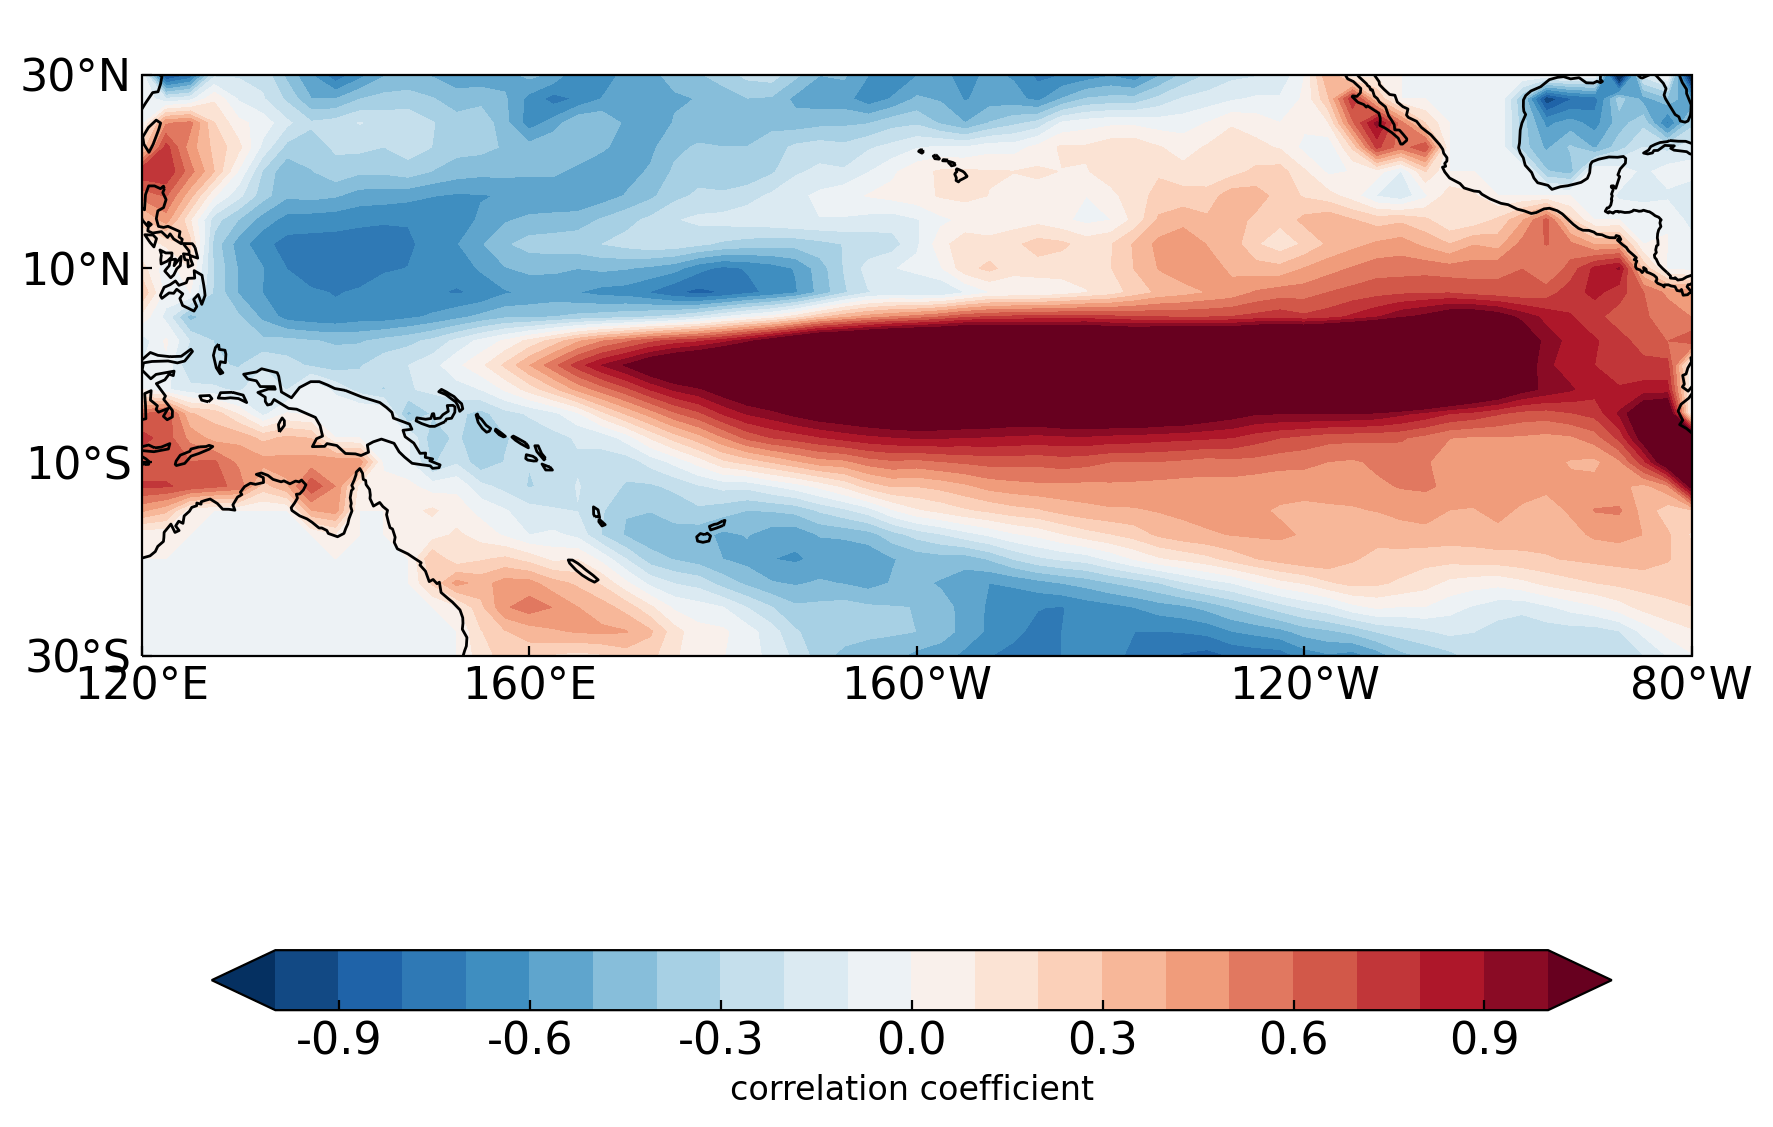

In [18]:
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 16})
# sns.set_theme(style="white")

clevs = np.linspace(-1, 1, 21)
projection = ccrs.PlateCarree(central_longitude=180)

fig = plt.figure(figsize=(10, 10), dpi = 100)
ax = fig.add_subplot(projection = projection)
ax.set_title(f' ', loc = 'left', fontsize = 18, fontweight = 'bold')
ax.set_xticks(np.linspace(-180, 180, 10), crs=projection)
ax.set_yticks(np.linspace(-90, 90, 10), crs=projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

cs = ds_mm[1, 5, 0, ...].plot.contourf(ax = ax,
                           cmap = plt.cm.RdBu_r,
                           add_colorbar = False,
                           transform=ccrs.PlateCarree(),
                           levels = clevs,
                           add_labels = False  # 用来消除没用的标题和轴名称
                           )

#                      [left, bottom, width, height]
cbar_ax = fig.add_axes([0.16, 0.18,   0.70,  0.03])
cb = plt.colorbar(cs, orientation='horizontal', cax = cbar_ax)
cb.set_label('correlation coefficient', fontsize=12)
ax.coastlines()